In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Developer Associate,131.419693,26.283939,33.810528,5
Azure DevOps Pipelines,196.532791,98.266395,105.369358,2
OAuth 2.0 RFC6749,246.055418,22.368674,32.703440,11
CCH Tax Forms Project,272.982900,12.999186,20.425517,21
pfSense,314.296174,26.191348,39.720675,12
Accounting,362.853354,21.344315,30.551050,17
Active Directory and Azure Files,486.183251,13.140088,23.125927,37
"The Starless Crown, Rollins",586.240113,21.712597,34.863927,27
Python + Oauth2.0,779.331424,33.883975,47.603291,23
FSLogix,981.971157,81.830930,114.475277,12


# Histogram

sum of ages: ~57011.99


<Axes: >

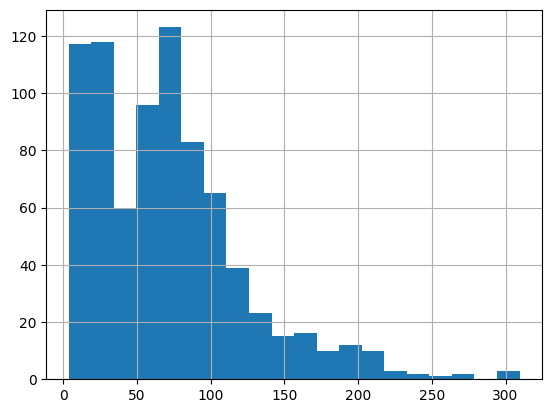

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~57011.99


<Axes: >

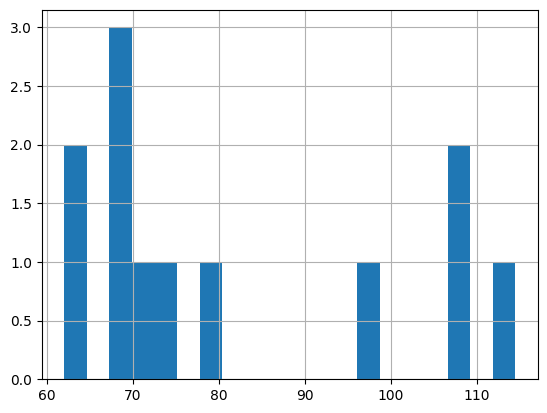

In [16]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='FSLogix']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [ ]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // 5

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


Cards found: 798
Total card age: 57011.99


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
5,Asynchronous Python,"Thread Pool Executor\nA thread pool executor, ...",102c628cf04ad4661a71d437cd297a11,309.514222,113.785888,-309.514222,3186.004861,0.893941,28,0,0,-309.514222
6,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,257.779303,113.785888,-309.514222,3186.004861,0.893941,28,1,0,-257.779303
7,Asynchronous Python,asyncio.Queue\nAn async-safe queue in Python u...,4282f8fb69ecf92a369e44e7e65e636a,203.409176,113.785888,-309.514222,3186.004861,0.893941,28,2,0,-203.409176
8,Asynchronous Python,Daemon Thread\nDaemon threads are background t...,4a2ba5e46ecb17805102a550ef1e904f,199.432953,113.785888,-309.514222,3186.004861,0.893941,28,3,0,-199.432953
9,Asynchronous Python,Thread Safety\nThread safety means that code o...,0542ccf7cce7d4c78fcf554c542ab5dc,146.246794,113.785888,-309.514222,3186.004861,0.893941,28,4,0,-146.246794
10,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,304.975096,68.597377,-304.975096,5281.997995,0.052984,77,0,0,-304.975096
11,Python,Q:\nWhat is the default exit code if a Python ...,b1c1e2234bc8df974f6b207465761b32,240.464781,68.597377,-304.975096,5281.997995,0.052984,77,1,0,-240.464781
12,Python,Q:\nWhy is lazy evaluation beneficial when dea...,97719b6814f21589c2cfe33ffa33f720,177.593324,68.597377,-304.975096,5281.997995,0.052984,77,2,0,-177.593324
13,Python,Which pathlib method can be used to iterate re...,69348be2860f4715a885a19d33138de7,174.850773,68.597377,-304.975096,5281.997995,0.052984,77,3,0,-174.850773
14,Python,Q:\nWhat is the advantage of using context man...,563a1ecce6595d5acf75240cfcd4fe91,170.889322,68.597377,-304.975096,5281.997995,0.052984,77,4,0,-170.889322


## Card Count

In [ ]:
n=4
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(2185.1557435454874)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
5,Asynchronous Python,"Thread Pool Executor\nA thread pool executor, ...",102c628cf04ad4661a71d437cd297a11,309.514222,113.785888,-309.514222,3186.004861,0.893941,28,0,0,-309.514222
10,Python,Q:\nHow can you define a custom exception in P...,42a1f83efefd4b56173827e48cae56f3,304.975096,68.597377,-304.975096,5281.997995,0.052984,77,0,0,-304.975096
0,Vocab,"How to Sell a Haunted House, Hendrix\nDebride ...",1cbf1056a2336f69233d814a8be086c8,303.910348,106.114932,-303.910348,5199.631649,0.608564,49,0,0,-303.910348
15,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,273.477993,110.626051,-273.477993,4203.789956,0.627520,38,0,0,-273.477993
16,PnP PowerShell,Invoke-RestMethod Parameters\nKey parameters i...,e6a04d0a76f2a4a9cba720d23ffea2c8,265.471998,110.626051,-273.477993,4203.789956,0.627520,38,1,0,-265.471998
6,Asynchronous Python,asyncio.wait_for()\nRuns a coroutine with a ti...,0ccadcbce46e58eb4de4907f7e86cbf9,257.779303,113.785888,-309.514222,3186.004861,0.893941,28,1,0,-257.779303
11,Python,Q:\nWhat is the default exit code if a Python ...,b1c1e2234bc8df974f6b207465761b32,240.464781,68.597377,-304.975096,5281.997995,0.052984,77,1,0,-240.464781
20,Terraform,Built-In Functions:\nDefinition: Terraform pro...,11db06afec8fe1222dc3a034c10f3ebe,237.921192,120.401916,-237.921192,1204.019158,0.395085,10,0,0,-237.921192
25,VMWare,ESXi Shell\n\nA command-line interface (CLI) u...,29e8247f5a2aa78b7ff2123ac06ccfee,232.456027,111.696467,-232.456027,3015.804616,0.477060,27,0,0,-232.456027
30,TSQL,Q: What is the purpose of the GROUP BY clause ...,48a62cc5d988221ac8669ebbd8b27594,232.037039,111.809658,-232.037039,2683.431784,0.603113,24,0,0,-232.037039


In [15]:
existing_cards['age'].mean()

np.float64(71.44360246577307)